In [299]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from myImageFolder import MyImageFolder
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from PIL import Image 

plt.ion()   # interactive mode

In [188]:
def plot_confusion_matrix(cm,idx,labels,cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(idx, labels, rotation=-90)
    plt.yticks(idx, labels)
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

In [189]:
# Data transformation for testing
data_transforms = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

data_dir = '/home/kaiyihuang/nexperia/new_data/test'
image_datasets = MyImageFolder(data_dir,data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32,shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
image_datasets[0][1]

'/home/kaiyihuang/nexperia/new_data/test/chipping/WEL91416811A_04-APG_ITIS_H13_2_115_3.bmp'

In [30]:
class_names

['chipping',
 'device_flip',
 'empty_pocket',
 'foreign_material',
 'good',
 'lead_defect',
 'lead_glue',
 'marking_defect',
 'pocket_damage',
 'scratch']

In [351]:
# load the trained model
model_dict = torch.load('resnet_18_dict.pt')
model_wts = model_dict['model_state_dict']

In [352]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

model_ft.load_state_dict(model_wts)

<All keys matched successfully>

In [46]:
def perf_measure_bad(y_actual, y_hat):
    TP = torch.mul(y_actual!=4,y_hat!=4).sum().item()
    FP = torch.mul(y_actual==4,y_hat!=4).sum().item()
    TN = torch.mul(y_actual==4,y_hat==4).sum().item()
    FN = torch.mul(y_actual!=4,y_hat==4).sum().item()    

    return (TP, FP, TN, FN)

In [47]:
def perf_measure_fm(y_actual, y_hat):
    TN = torch.mul(y_actual!=3,y_hat!=3).sum().item()
    FN = torch.mul(y_actual==3,y_hat!=3).sum().item()
    TP = torch.mul(y_actual==3,y_hat==3).sum().item()
    FP = torch.mul(y_actual!=3,y_hat==3).sum().item()    

    return (TP, FP, TN, FN)

In [48]:
def good_to_false_fm(y_actual, y_hat):
    f_fm = torch.mul(y_actual==4,y_hat==3).sum().item()
    
    return f_fm

In [33]:
# test resnet_18_good_bad
model_ft.eval()
results = pd.DataFrame(columns=['id','label','prediction','score'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)

    labels = (labels!=4).type(torch.LongTensor)
    labels = labels.to(device)


    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP = torch.mul(labels.data==1,preds==1).sum().item()
    FP = torch.mul(labels.data==0,preds==1).sum().item()
    TN = torch.mul(labels.data==0,preds==0).sum().item()
    FN = torch.mul(labels.data==1,preds==0).sum().item()

    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu(),'score':probs.detach().cpu()})
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)[:,1]
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, auc_ovr))

results.to_csv('test_result_resnet_18_good_bad.csv',index=False)

Test acc: 0.9875 TPR: 0.9717 TNR: 0.9915 AUC: 0.9968


In [37]:
results.label.unique()

array([0, 1], dtype=object)

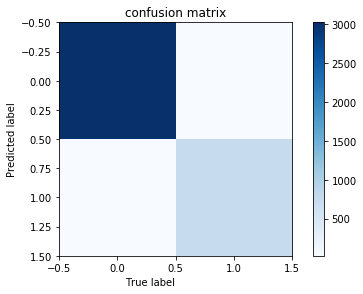

In [42]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred>=0.5)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm.T)

In [348]:
# test resnet_18_weighted with heavier penalty on bad data especially for foreign material defect
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted_overall_heavier_penalty_esp_for_fm.csv',index=False)

Test acc: 0.7094 TPR: 0.9961 TNR: 0.6740 TPR_fm: 0.9487 TNR_fm: 0.8418 fm/FP: 0.5327 AUC_bad: 0.9841 AUC_fm: 0.9616 AUC: 0.9808


In [9]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted_overall_heavier_penalty_esp_for_fm.pt')

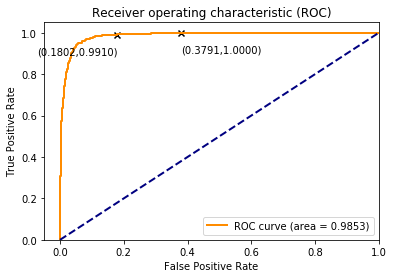

In [338]:
fpr_4, tpr_4, thresholds_4 = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr_4, tpr_4, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_4[-2],tpr_4[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_4[-2],tpr_4[-2]), # this is the text
                 (fpr_4[-2],tpr_4[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_4[-15],tpr_4[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_4[-15],tpr_4[-15]), # this is the text
                 (fpr_4[-15],tpr_4[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='right',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_overall_heavier_penalty_esp_for_fm_roc.jpg')
plt.show()

[[2041    0    1    0    0    0    0    0    0    1]
 [ 108  310    0    0    4    1    0    0    0   14]
 [   6    0   12    0    0    0    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [ 514   17    0    0  185    2    0    0    1   28]
 [ 198    1    1    0    1   20    0    0    0    1]
 [  70    3    0    0    1    1   62    0    0    0]
 [  25    0    0    0    0    1    0   18    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  90   37    0    0    4    0    0    0    0   31]]


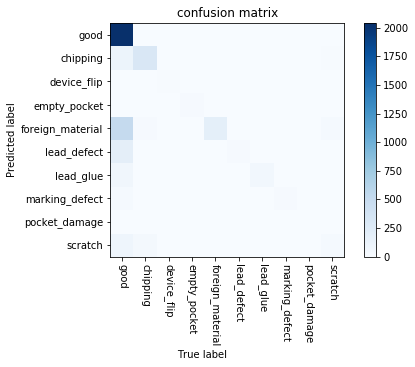

In [342]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm.T)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 776    2]
 [1011 2041]]


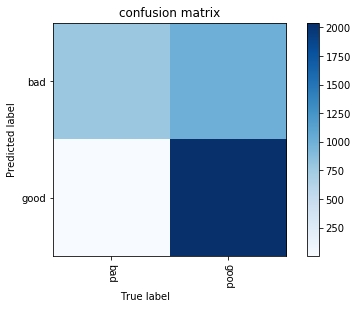

In [343]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 185   10]
 [ 562 3073]]


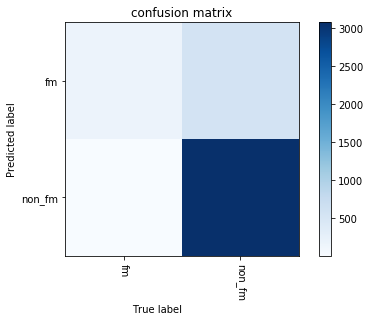

In [344]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [159]:
class_names

['chipping',
 'device_flip',
 'empty_pocket',
 'foreign_material',
 'good',
 'lead_defect',
 'lead_glue',
 'marking_defect',
 'pocket_damage',
 'scratch']

In [349]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label          
good       chipping      1
           lead_defect   1
           scratch       1

In [298]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')]['id']

9    /home/kaiyihuang/nexperia/new_data/test/chippi...
5    /home/kaiyihuang/nexperia/new_data/test/lead_d...
0    /home/kaiyihuang/nexperia/new_data/test/lead_d...
Name: id, dtype: object

In [350]:
for i in results[(results['label']!=results['prediction']) & (results['prediction']=='good')]['id']:
    print(i)
    # open method used to open different extension image file 
    im = Image.open(i)  

    # This method will show image in any image viewer  
    im.show() 

/home/kaiyihuang/nexperia/new_data/test/lead_defect/WEL93514258A_55-APG_ITIS_H09_1_67_3.bmp
/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93855011A_01-APG_ITIS_H46_1_76_4.bmp
/home/kaiyihuang/nexperia/new_data/test/scratch/WEP938425D5A_01-APG_ITIS_H52_2_397_2.bmp


In [310]:
im = Image.open('/home/kaiyihuang/nexperia/new_data/test/chipping/WEP93734754A_02-APG_ITIS_H09_1_859_3.bmp')  

# This method will show image in any image viewer  
im.show() 

In [269]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction     
foreign_material chipping      5
                 lead_defect   1
                 scratch       6

In [12]:
results[(results['label']!=results['prediction']) & (results['label']=='good')].groupby(['label','prediction']).count()[['id']]

id
label prediction           
good  chipping          105
      device_flip         3
      foreign_material  518
      lead_defect       209
      lead_glue          71
      marking_defect     25
      scratch            77

In [13]:
results[(results['label']!=results['prediction']) & (results['prediction']=='foreign_material')].groupby(['prediction','label']).count()[['id']]

id
prediction       label             
foreign_material chipping        23
                 good           518
                 lead_defect      3
                 pocket_damage    1
                 scratch         29

In [334]:
# test resnet_18_weighted with heavier penalty on falsely predict an actual foreign material defect
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
# auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted_heavier_penalty_fm',index=False)

Test acc: 0.9277 TPR: 0.9743 TNR: 0.9548 TPR_fm: 0.9282 TNR_fm: 0.9623 fm/FP: 0.5652 AUC_bad: 0.9937 AUC_fm: 0.9885 AUC: 0.9922


In [25]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted_heavier_penalty_fm.pt')

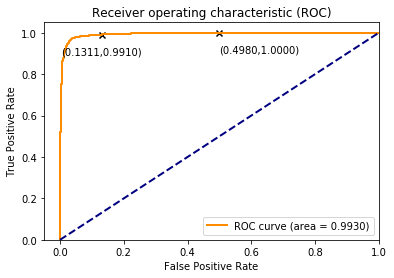

In [333]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_3[-2],tpr_3[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_3[-2],tpr_3[-2]), # this is the text
                 (fpr_3[-2],tpr_3[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_3[-15],tpr_3[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_3[-15],tpr_3[-15]), # this is the text
                 (fpr_3[-15],tpr_3[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_heavier_penalty_fm_roc.jpg')
plt.show()

[[2908   19    0    0   83   11    9    2    0   20]
 [  12  294    0    0   21    1    0    0    0   40]
 [   1    0   13    0    0    0    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [   3    5    0    0  180    1    1    0    0    5]
 [   3    2    0    0    1   19    0    0    0    0]
 [   0    0    0    0    0    0   62    0    0    0]
 [   0    0    0    0    0    0    0   18    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   3   14    0    0   25    0    1    0    0   32]]


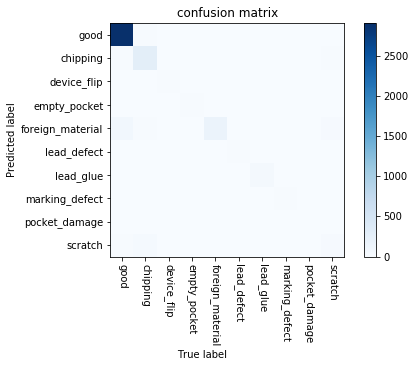

In [170]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 756   22]
 [ 144 2908]]


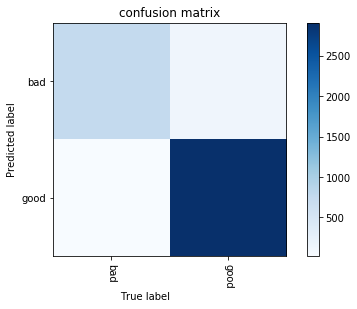

In [171]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 180   15]
 [ 131 3504]]


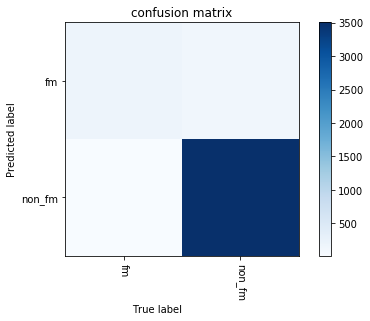

In [172]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [146]:
np.concatenate((np.array(cm[0,0]).reshape(1,1), np.sum(cm[:,1:],axis=1).reshape(1,-1)),axis=1).shape

(1, 11)

In [148]:
cm[:,1:].shape

(10, 9)

In [36]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping          12
           device_flip        1
           foreign_material   1
           lead_defect        3
           scratch            3

In [37]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction     
foreign_material chipping      6
                 good          1
                 lead_defect   1
                 scratch       5

In [15]:
# test resnet_18_weighted with batch_size=8
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = running_TP = running_TN = running_FP = running_FN = 0

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    result = pd.DataFrame({'id':names,'label':labels.data.cpu(),'prediction':preds.cpu()})
    results = results.append(result)


    
acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f}'.format(acc, TPR, TNR))

results.to_csv('test_result_resnet_18_weighted_batch_size_8.csv',index=False)

Test acc: 0.9559 TPR: 0.9756 TNR: 0.9780


In [16]:
results[(results['label']!=results['prediction']) & (results['prediction']==4)].groupby(['label']).count()

,id,prediction
label,,
0,8,8
1,1,1
3,7,7
5,2,2
9,1,1


In [17]:
results[results['label']!=results['prediction']].groupby(['prediction','label']).count()

id
prediction label    
0.0        3       7
           4      24
           5       1
           9      15
3.0        0       4
           4      27
           5       1
           8       1
           9      17
4.0        0       8
           1       1
           3       7
           5       2
           9       1
5.0        4       5
           9       1
6.0        4       2
7.0        4       2
9.0        0      26
           3      10
           4       7

In [18]:
results[results['label']!=results['prediction']].groupby(['label','prediction']).count()

id
label prediction    
0     3.0          4
      4.0          8
      9.0         26
1     4.0          1
3     0.0          7
      4.0          7
      9.0         10
4     0.0         24
      3.0         27
      5.0          5
      6.0          2
      7.0          2
      9.0          7
5     0.0          1
      3.0          1
      4.0          2
8     3.0          1
9     0.0         15
      3.0         17
      4.0          1
      5.0          1

In [328]:
# test resnet_18_weighted
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted.csv',index=False)

Test acc: 0.9350 TPR: 0.9859 TNR: 0.9584 TPR_fm: 0.8359 TNR_fm: 0.9827 fm/FP: 0.3071 AUC_bad: 0.9951 AUC_fm: 0.9853 AUC: 0.9932


In [10]:
model_dict['test_acc'] = acc
model_dict['test_TPR'] = TPR
model_dict['test_TNR'] = TNR
model_dict['test_TPR_fm'] = TPR_fm
model_dict['test_TNR_fm'] = TNR_fm
model_dict['test_f_fm_rate'] = f_fm_rate
model_dict['test_AUC_bad'] = auc_bad
model_dict['test_AUC_fm'] = auc_fm
model_dict['test_AUC'] = auc_ovr
torch.save(model_dict,'resnet_18_dict_weighted.pt')

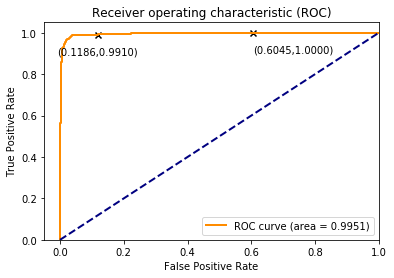

In [329]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr_2[-2],tpr_2[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_2[-2],tpr_2[-2]), # this is the text
                 (fpr_2[-2],tpr_2[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr_2[-15],tpr_2[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr_2[-15],tpr_2[-15]), # this is the text
                 (fpr_2[-15],tpr_2[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_weighted_roc.jpg')
plt.show()

[[2928   35    0    0   26   22    6    1    0   34]
 [   5  325    0    0    5    1    0    0    0   32]
 [   1    0   12    0    0    1    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [   2   12    1    0  160    2    2    0    0   16]
 [   2    2    0    0    1   20    0    0    0    0]
 [   0    0    0    0    0    0   62    0    0    0]
 [   0    0    0    0    0    0    0   18    0    0]
 [   0    0    0    0    0    0    0    0    0    1]
 [   2   13    0    0   14    0    0    0    0   46]]


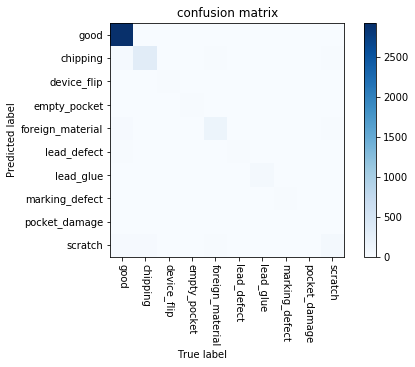

In [178]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in idx])

[[ 766   12]
 [ 124 2928]]


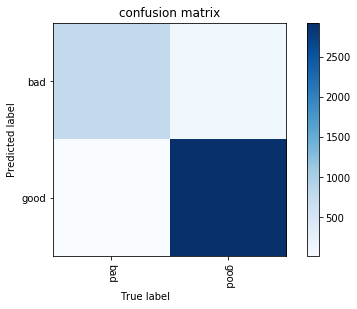

In [179]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 160   35]
 [  46 3589]]


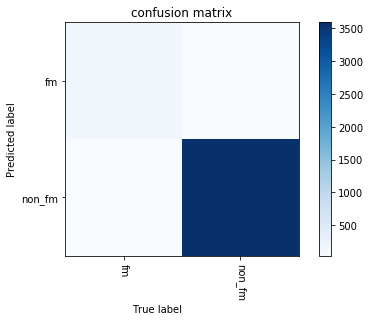

In [180]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [39]:
results = pd.read_csv('test_result_resnet_18_weighted.csv')

In [41]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping           4
           device_flip        1
           foreign_material   2
           lead_defect        2
           lead_glue          1
           scratch            3

In [42]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction        
foreign_material chipping        12
                 device_flip      1
                 good             2
                 marking_defect   1
                 scratch         13

In [353]:
# test resnet_18
model_ft.eval()
results = pd.DataFrame(columns=['id','label'])

running_corrects = 0
running_TP = running_TN = running_FP = running_FN = 0
running_TP_fm = running_TN_fm = running_FP_fm = running_FN_fm = 0
running_f_fm = 0
y_true = []
y_pred = []

for i, ((inputs, labels), names) in enumerate(dataloaders, 0):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
                
    running_corrects += torch.sum(preds == labels.data)
    
    TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
    running_TP += TP
    running_FP += FP
    running_TN += TN
    running_FN += FN
    
    TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
    running_TP_fm += TP_fm
    running_FP_fm += FP_fm
    running_TN_fm += TN_fm
    running_FN_fm += FN_fm

    f_fm = good_to_false_fm(labels.data,preds)
    running_f_fm += f_fm

    m = nn.Softmax(dim=1)
    probs = m(outputs)

    y_true.append(labels.data.cpu())
    y_pred.append(probs.cpu())
    
    result = pd.DataFrame({'id':names,'label':labels.detach().cpu(),'prediction':preds.detach().cpu()})
    for i, class_name in enumerate(class_names):
        result['{}_score'.format(class_name)] = probs.detach().cpu()[:,i]
    results = results.append(result)

acc = running_corrects.double() / dataset_sizes

if (running_TP+running_FN==0):
    TPR = float('nan')
else:
    TPR = running_TP / (running_TP + running_FN)
if (running_TN+running_FP==0):
    TNR = float('nan')
else:
    TNR = running_TN / (running_TN + running_FP)

if (running_TP_fm+running_FN_fm==0):
    TPR_fm = float('nan')
else:
    TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
if (running_TN_fm+running_FP_fm==0):
    TNR_fm = float('nan')
else:
    TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
if (running_FP==0):
    f_fm_rate = float('nan')
else:
    f_fm_rate = running_f_fm / running_FP

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_bad = y_true!=4
y_fm = y_true==3
y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
y_fm_score = y_pred[:,3]
auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
auc_ovr = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')
auc_ovo = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovo')
fpr, tpr, thresholds = roc_curve(y_bad, y_bad_score)

print('Test acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f} AUC_bad: {:.4f} AUC_fm: {:.4f} AUC: {:.4f}'
      .format(acc, TPR, TNR, TPR_fm, TNR_fm, f_fm_rate, auc_bad, auc_fm, auc_ovr))

results['label'] = results['label'].apply(lambda i: class_names[i])
results['prediction'] = results['prediction'].astype('int').apply(lambda i: class_names[i])

results.to_csv('test_result_resnet_18_weighted.csv',index=False)

Test acc: 0.9637 TPR: 0.9550 TNR: 0.9938 TPR_fm: 0.8718 TNR_fm: 0.9906 fm/FP: 0.2632 AUC_bad: 0.9970 AUC_fm: 0.9914 AUC: 0.9959


In [361]:
tpr

array([0.        , 0.00128535, 0.00899743, 0.01156812, 0.05398458,
       0.05655527, 0.1311054 , 0.13367609, 0.49614396, 0.49614396,
       0.66709512, 0.66709512, 0.6722365 , 0.6722365 , 0.71979434,
       0.71979434, 0.75578406, 0.75578406, 0.78534704, 0.78534704,
       0.83547558, 0.83547558, 0.88431877, 0.88431877, 0.89203085,
       0.89203085, 0.89974293, 0.89974293, 0.91902314, 0.91902314,
       0.92030848, 0.92030848, 0.92673522, 0.92673522, 0.92930591,
       0.92930591, 0.93701799, 0.93701799, 0.94215938, 0.94215938,
       0.94858612, 0.94858612, 0.95115681, 0.95115681, 0.95758355,
       0.95758355, 0.96143959, 0.96143959, 0.96529563, 0.96529563,
       0.96786632, 0.96786632, 0.96915167, 0.96915167, 0.97043702,
       0.97043702, 0.97172237, 0.97172237, 0.97429306, 0.97429306,
       0.97557841, 0.97557841, 0.97686375, 0.97686375, 0.9781491 ,
       0.9781491 , 0.97943445, 0.97943445, 0.98200514, 0.98200514,
       0.98329049, 0.98329049, 0.98457584, 0.98457584, 0.98586

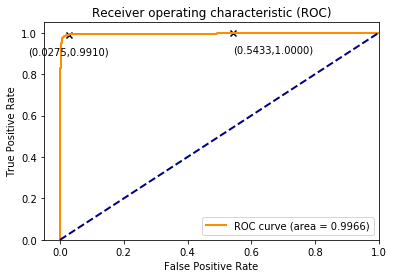

In [325]:
fpr, tpr, thresholds = roc_curve(y_bad, y_bad_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr[-2],tpr[-2],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr[-2],tpr[-2]), # this is the text
                 (fpr[-2],tpr[-2]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='left')# horizontal alignment can be left, right or center
plt.scatter(fpr[-15],tpr[-15],c='black',marker='x')
plt.annotate('({:.4f},{:.4f})'.format(fpr[-15],tpr[-15]), # this is the text
                 (fpr[-15],tpr[-15]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center',) # horizontal alignment can be left, right or center

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('resnet_18_roc.jpg')
plt.show()

[[3026   15    0    0   10    0    0    0    0    1]
 [   9  347    0    0    5    1    0    0    0    6]
 [   1    1   12    0    0    0    0    0    0    0]
 [   0    0    0   20    0    0    0    0    0    0]
 [   9   15    0    0  166    0    0    0    0    5]
 [   4    2    1    0    1   17    0    0    0    0]
 [   1    0    0    0    0    0   61    0    0    0]
 [   0    0    0    0    0    0    0   18    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   4   22    0    0   17    0    0    0    0   32]]


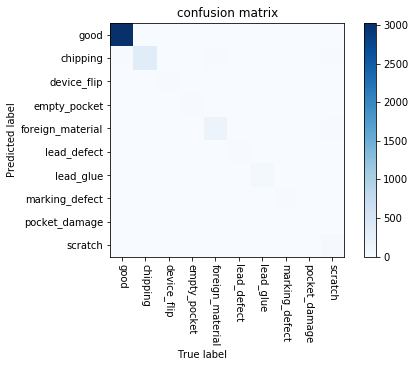

In [184]:
# confusion matrix
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [4,0,1,2,3,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
print(cm)
plot_confusion_matrix(cm.T,range(10),[class_names[i] for i in [4,0,1,2,3,5,6,7,8,9]])

[[ 750   28]
 [  26 3026]]


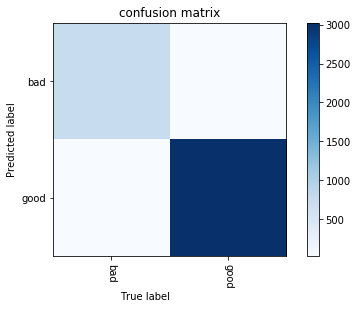

In [185]:
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
idx_2 = [1,0]
cm_2 = cm_2[:,idx_2]
cm_2 = cm_2[idx_2,:]
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['bad', 'good'])

[[ 166   29]
 [  34 3601]]


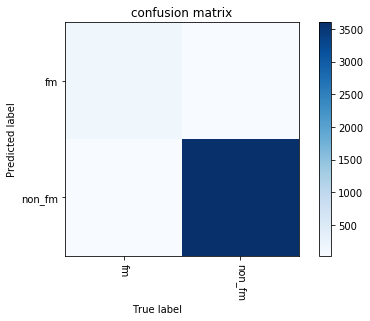

In [186]:
# confusion matrix fm
cm = confusion_matrix(results.label.to_numpy(), results.prediction.to_numpy())
idx = [3,0,1,2,4,5,6,7,8,9]
cm = cm[:,idx]
cm = cm[idx,:]
cm_2 = np.array([[cm[0,0], np.sum(cm[0,1:])],
                 [np.sum(cm[1:,0]), np.sum(cm[1:,1:])]])
print(cm_2)
plot_confusion_matrix(cm_2.T,[0,1],['fm', 'non_fm'])

In [91]:
[class_names[i]]

['chipping']

In [60]:
image_datasets.class_to_idx

{'chipping': 0,
 'device_flip': 1,
 'empty_pocket': 2,
 'foreign_material': 3,
 'good': 4,
 'lead_defect': 5,
 'lead_glue': 6,
 'marking_defect': 7,
 'pocket_damage': 8,
 'scratch': 9}

In [22]:
results[(results['label']!=results['prediction']) & (results['prediction']=='good')].groupby(['prediction','label']).count()[['id']]

id
prediction label               
good       chipping          10
           device_flip        1
           foreign_material   5
           lead_defect        5
           marking_defect     1
           scratch            6

In [354]:
results[(results['label']!=results['prediction']) & (results['label']=='good')].groupby(['label','prediction']).count()[['id']]

id
label prediction          
good  chipping          13
      foreign_material   5
      scratch            1

In [360]:
for i in results[(results['label']!=results['prediction']) & (results['label']=='good')]['id']:
    print(i)
    print(results[results['id']==i]['prediction'])

/home/kaiyihuang/nexperia/new_data/test/good/WEP937405K1A_01-Z7W-ITISA45-2_369_1.bmp
10    foreign_material
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP937023H4A_11-A4W-ITISA47-1_65_2.bmp
2    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEL927267D5A_21-WCM-ITISA53-2_25_3.bmp
3    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEE93900190A_14-1FW-ITISA44-2_163_2.bmp
16    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEL93728915A_46-6BW-ITISA54-1_90_2.bmp
4    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP93714351A_09-TVW-ITISA43-2_384_1.bmp
26    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP937154U3A_06-A7W-ITISA45-2_287_4.bmp
6    chipping
Name: prediction, dtype: object
/home/kaiyihuang/nexperia/new_data/test/good/WEP936218H4A_05-3GW-ITISA49-1_

In [23]:
results[(results['label']!=results['prediction']) & (results['label']=='foreign_material')].groupby(['label','prediction']).count()[['id']]

id
label            prediction    
foreign_material chipping    14
                 good         5
                 scratch      7

In [49]:
results[(results['label']!=results['prediction']) & (results['prediction']==4)].groupby(['label']).count()

,id,prediction
label,,
0,16,16
1,1,1
3,11,11
5,6,6
9,3,3


In [52]:
results[results['label']!=results['prediction']].groupby(['prediction','label']).count()

id
prediction label    
0.0        3       8
           4      12
           5       3
           9      21
1.0        5       1
3.0        0       3
           4       8
           5       1
           6       1
           8       1
           9      19
4.0        0      16
           1       1
           3      11
           5       6
           9       3
5.0        1       2
9.0        0      12
           3       7

In [274]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [288]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, ((inputs, labels), names) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if preds[j]!=labels.data[j] and preds[j]==4:
                    images_so_far += 1
                    ax = plt.subplot(1, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

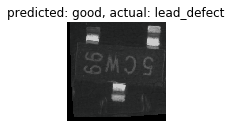

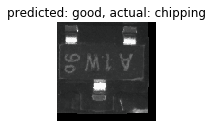

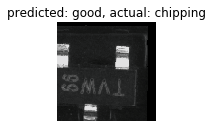

In [289]:
# FP
visualize_model(model_ft,3)

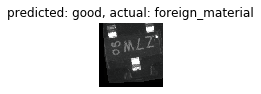

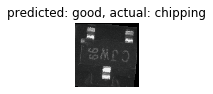

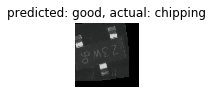

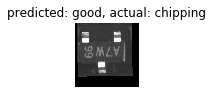

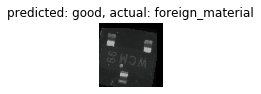

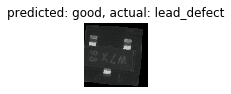

In [29]:
# FP
visualize_model(model_ft)

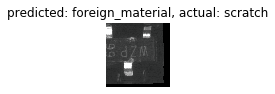

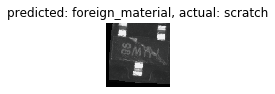

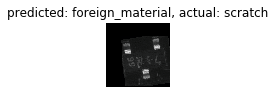

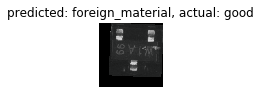

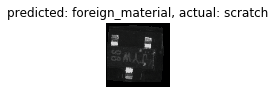

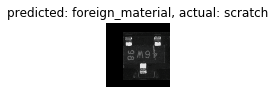

In [32]:
# FN foreign material
visualize_model(model_ft)

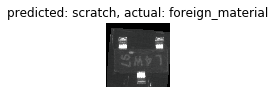

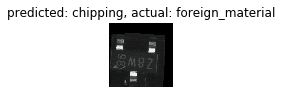

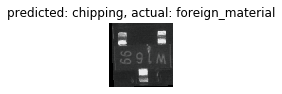

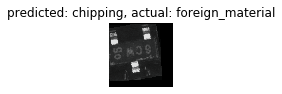

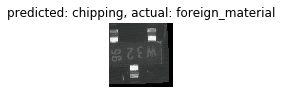

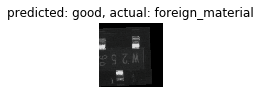

In [34]:
# FP foreign material
visualize_model(model_ft)

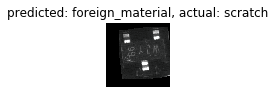

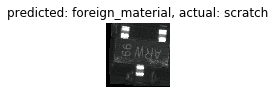

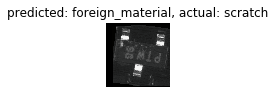

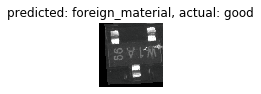

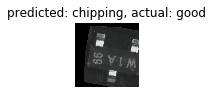

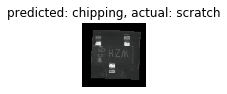

In [36]:
# bad predictions
visualize_model(model_ft)

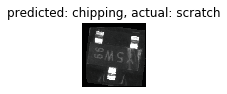

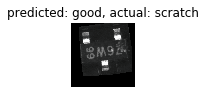

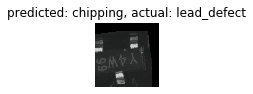

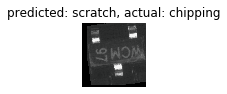

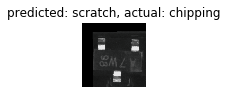

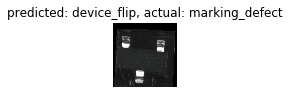

In [37]:
visualize_model(model_ft)

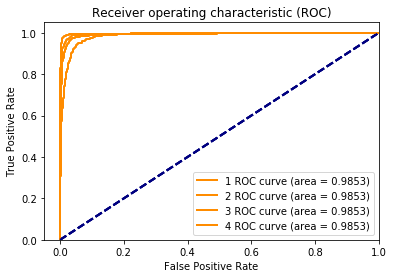

In [341]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='1 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='2 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='3 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_4, tpr_4, color='darkorange',
         lw=lw, label='4 ROC curve (area = %0.4f)' % auc_bad)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc.jpg')
plt.show()